## Python Program for converting PCS(EPSG:3411) into GCS(EPSG:4326)

>1. EPSG:3411 NSIDC Sea Ice Polar Stereographic North 
>2. EPSG:4326 WGS 84
>3.  [Online EPSG Transfer coordinates](<http://epsg.io/transform#s_srs=3411&t_srs=4326>)


20190402 skx added interpolate 2d code


In [1]:
from pyproj import Proj, transform
from netCDF4 import Dataset
import numpy as np

In [4]:
"Simple test - One point"
inProj = Proj(init='epsg:3411')
outProj = Proj(init='epsg:4326')
x1,y1 = -3846875.0,-5346875.0
x2,y2 = transform(inProj,outProj,x1,y1)
print(x2,y2)

-80.733592444807 33.95657294587319


In [2]:
"Convert coordinate system 1"
'''EPSG 3411 to EPSG 4326'''
def ConCoor(x1,y1):
    inProj = Proj(init='epsg:3411')
    outProj = Proj(init='epsg:4326')
    x2,y2 = transform(inProj,outProj,x1,y1)
    #print(x2,y2)
    return x2,y2

In [3]:
"Load data"
'''6.25km x 6.25km sea-ice-concentration data'''
def ReadSIC(filename):
    file = Dataset(filename)
    sic = file.variables['z'][:]    # 1216 x 1796 
    x = file.variables['x'][:]      # 1216
    y = file.variables['y'][:]      # 1796
    return sic,x,y

In [6]:
if __name__ == '__main__':
    filename = "C:\\Users\\kathy\\research\\Sea-ice-concentration\\data\\UB\\sic\\asi-AMSR2-n6250-20180905-v5.4.nc"
    sic,x,y = ReadSIC(filename)
    xs=np.size(x)
    ys=np.size(y)
    xg = np.zeros((xs,ys))
    yg = np.zeros((xs,ys))
    n=0
    for i in range(len(x)):
        for j in range(len(y)):
            n=n+1
            xg[i,j]= ConCoor(x[i],y[j])[0]
            yg[i,j] = ConCoor(x[i],y[j])[1]
    print('ok') 
    print(n)
    print(xs*ys)

ok
2179072
2179072


In [23]:
"Interpolate 2d demo"
from scipy import interpolate
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='cubic')

print(f)

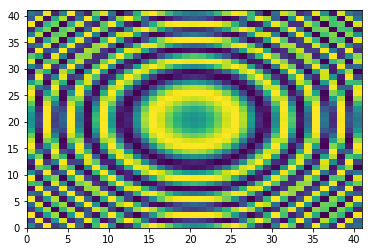

In [27]:
## Now, display z
import matplotlib.pyplot as plt
plt.pcolor(z)
plt.show()

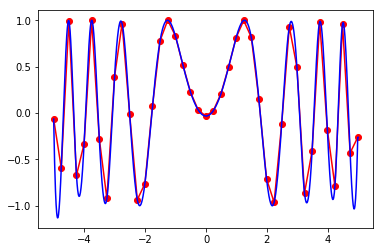

In [25]:
xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)
znew = f(xnew, ynew)
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

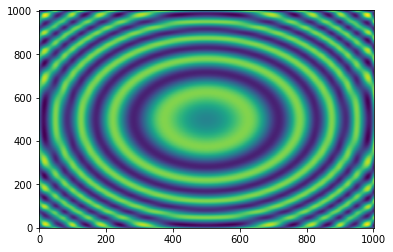

In [26]:
## Now, display the znew
import matplotlib.pyplot as plt
plt.pcolor(znew)
plt.show()

In [7]:
"Round xg and yg up to second decimal with lower resolution(0.25 deg)"
xl=np.zeros((xs,ys))
yl=np.zeros((xs,ys))
for i in range(len(x)):
    for j in range(len(y)): 
        #print(xg[i,j],yg[i,j])
        xt=xg[i,j]
        yt=yg[i,j]
        xl[i,j]=round(xt/0.25)*0.25
        yl[i,j]=round(yt/0.25)*0.25

In [6]:
print(xs,ys)

1216 1792


In [8]:
'''Convert Lon limits:(-180,180) to (0,360)'''
xn = np.where(xl>0.0,xl,xl+360)
xl = xn

In [9]:
'''Create lat/lon grids'''
lon = np.arange(0,360,0.25)
lat = np.arange(30.25,90,0.25)
lon_2d,lat_2d = np.meshgrid(lon,lat)
print(np.shape(lat_2d))

#ind = np.where(lon == xl)
#print(np.size(ind))

(240, 1440)


In [208]:
l1=np.arange(10)
print(l1)
l2=[0,3,5,12,13,15]
t=set(l1).intersection(l2)
print(list(t))

[0 1 2 3 4 5 6 7 8 9]
[0, 3, 5]


In [226]:
print(lon[0],lat[0])
np.where(xl==lon[1])

0.0 30.0


(array([ 693,  694,  695, ..., 1215, 1215, 1215], dtype=int64),
 array([779, 778, 777, ..., 261, 262, 263], dtype=int64))

In [40]:
np.max(yl-30)/0.25

240.0

In [60]:
c=np.zeros((1440,240))
sic_g = np.zeros((1440,240))
for i in range(1216):
    for j in range(1792):
        #print(xl[i,j],yl[i,j])
        #m=np.where(lon==xl[i,j])
        #n=np.where(lat==yl[i,j])
        m=int(xl[i,j]/0.25)
        if m==1440:
            m=0
        n=int((yl[i,j]-30)/0.25)
        if n==240:
            n=239
        #print(mt,nt,m,n)
        sic_g[m,n]=sic_g[m,n]+sic_UB[i,j]
        c[m,n]=c[m,n]+1
        

C:\Users\kathy\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Warning: converting a masked element to nan.
  from ipykernel import kernelapp as app


In [78]:
t=np.where(c==np.min(c))
np.max()

nan

In [59]:
sic_UB=sic.T
print(np.shape(sic_UB))

(1216, 1792)


In [65]:
sic_t=np.zeros((1440,240))
for m in range(1440):
    for n in range(240):
        if c[m,n]!=0:
            sic_t[m,n]=sic_g[m,n]/c[m,n]
        else:
            sic_t[m,n]=-1000

In [67]:
np.min(sic_t)

nan

In [ ]:
"Remap sea-ice-congcentration into geographic coordinate system"
sic_g = np.zeros((1440,240))   # sic_g, sea ice concentration in geographic coordinate system from 30N to 90N.
for i in range(len(lon)):
    for j in range(len(lat)):
        if xl==
        w = np.where()
        sic_g[i,j] = sic_g[i,j]+

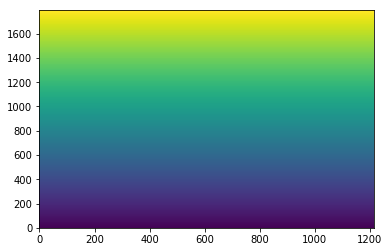

In [85]:
import matplotlib.pyplot as plt
x2d,y2d = np.meshgrid(x,y)
plt.pcolor(y2d)

In [95]:
print(x[615],x[616])
print(y[855],y[856])

-3125.0 3125.0
-3125.0 3125.0
